In [1]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, build_network, detect_extrema_dot_motion
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def make_hanks_behavior_dataframe():
    # convert original matlab files into a single pandas dataframe
    dfs = []
    columns = ('type', 'id', 'emphasis', 'trial', 'coherence', 'accuracy', 'RT')

    for name in ['E', 'D']:
        if name=='E': emp = scipy.io.loadmat("data/behavData_eli.mat", simplify_cells=True)
        if name=='D': emp = scipy.io.loadmat("data/behavData_dam.mat", simplify_cells=True)
        for e, emphasis in enumerate(['speed', 'accuracy']):
            cond = emp['task'][e]
            coherences = 100*cond['data']['coh']
            accuracies = 100*cond['data']['cor']
            rts = 0.001*cond['data']['rt']
            trials = coherences.shape[0]
            for t in range(trials):
                dfs.append(pd.DataFrame([['monkey', name, emphasis, t, coherences[t], accuracies[t], rts[t]]], columns=columns))

    hanks_behavior = pd.concat(dfs, ignore_index=True)
    hanks_behavior.to_pickle("data/hanks2014_behavior.pkl")

In [3]:
# make_hanks_behavior_dataframe()

In [2]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_error(simulated, empirical, coherences, emphases, bins):
    for emphasis in emphases:
        chis = []
        accs = []
        for coherence in coherences:
            rts_sim = simulated.query("emphasis==@emphasis & coherence==@coherence")['RT'].to_numpy()
            rts_emp = empirical.query("emphasis==@emphasis & coherence==@coherence")['RT'].to_numpy()
            accs_sim = simulated.query("emphasis==@emphasis & coherence==@coherence")['accuracy'].to_numpy()
            accs_emp = empirical.query("emphasis==@emphasis & coherence==@coherence")['accuracy'].to_numpy()
            hist_rts_sim = np.histogram(rts_sim, bins=bins)[0]
            hist_rts_emp = np.histogram(rts_emp, bins=bins)[0]
            normed_hist_rts_sim = hist_rts_sim / len(rts_sim)
            normed_hist_rts_emp = hist_rts_emp / len(rts_emp)
            chi = chi_squared_distance(normed_hist_rts_sim, normed_hist_rts_emp)
            acc = np.abs(np.mean(accs_sim) - np.mean(accs_emp))
            chis.append(chi)
            accs.append(acc)
        print('emphasis', emphasis, f'chi2 {np.sum(chis):.3}', f'accuracy {np.sum(accs):.3}')

# Empirical

In [4]:
def compare_monkeys():
    hanks_behavior = pd.read_pickle("data/hanks2014_behavior.pkl").query("coherence>0")
    cohs = 100*np.array([0.032, 0.064, 0.128, 0.256, 0.512])
    error = ('ci', 95)
    bins = np.arange(0, 1.5, 0.1)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=hanks_behavior.query("emphasis=='speed'"), x='coherence', y='RT', hue='id',
                 palette=palette[:2], markers=True, ax=axes[0][0],
                 errorbar=error, estimator=np.median)
    sns.lineplot(data=hanks_behavior.query("emphasis=='accuracy'"), x='coherence', y='RT', hue='id',
                 palette=palette[:2], markers=True, ax=axes[0][1],
                 errorbar=error, estimator=np.median)
    sns.lineplot(data=hanks_behavior.query("emphasis=='speed'"), x='coherence', y='accuracy', hue='id',
                 palette=palette[:2], markers=True, ax=axes[1][0],
                 errorbar=error, estimator=np.mean)
    sns.lineplot(data=hanks_behavior.query("emphasis=='accuracy'"), x='coherence', y='accuracy', hue='id',
                 palette=palette[:2], markers=True, ax=axes[1][1],
                 errorbar=error, estimator=np.mean)
    axes[0][0].set(ylabel="Response Time (s)", title='speed emphasis')
    axes[0][1].set(ylabel="Response Time (s)", title='accuracy emphasis')
    axes[0][0].legend()
    axes[1][0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)")
    axes[1][1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)")
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    
    fig = sns.FacetGrid(hanks_behavior, col='emphasis', row="coherence", hue='id', palette=palette[:2],
                        height=1.5, aspect=3, sharex=True, legend_out=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins[::2])
    fig.set(yticks=[0,25,50,75,100])
    fig.add_legend()

In [6]:
# compare_monkeys()

In [5]:
def plot_emp_firing_rates():
    emp = scipy.io.loadmat("data/psthData.mat", simplify_cells=True)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)), sharey=True, sharex=True)
    sns.lineplot(emp['psth_forBo_acc'][0], color=palette[0], ax=axes[0])
    sns.lineplot(emp['psth_forBo_acc'][1], color=palette[1], ax=axes[0])
    sns.lineplot(emp['psth_forBo_acc'][2], color=palette[2], ax=axes[0])
    sns.lineplot(emp['psth_forBo_acc'][3], color=palette[3], ax=axes[0])
    sns.lineplot(emp['psth_forBo_acc'][4], color=palette[4], ax=axes[0])
    sns.lineplot(emp['psth_forBo_sp'][0], color=palette[0], ax=axes[1])
    sns.lineplot(emp['psth_forBo_sp'][1], color=palette[1], ax=axes[1])
    sns.lineplot(emp['psth_forBo_sp'][2], color=palette[2], ax=axes[1])
    sns.lineplot(emp['psth_forBo_sp'][3], color=palette[3], ax=axes[1])
    sns.lineplot(emp['psth_forBo_sp'][4], color=palette[4], ax=axes[1])
    axes[0].set(ylabel='Firing Rate', xlabel='Time (ms)', title='Accuracy Emphasis')
    axes[1].set(xlabel='Time (ms)', title='Speed Emphasis')
    plt.tight_layout()
    fig.savefig(f"plots/hanks_psth.png", dpi=600)

In [8]:
# plot_emp_firing_rates()

# Simulate

In [9]:
def simulate(
        coherences=np.array([0.032, 0.064, 0.128, 0.256, 0.512]),
        emphases=['speed', 'accuracy'],
        pid="E",
        ramps=[1.0, 1.0],
        thresholds=[0.3, 0.3],
        relatives=[0.5, 0.5],
        sigmas=[0.5, 0.5],
        dt_samples=[0.03, 0.03],
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(60, 80),
        rA=1.0,
        trials=10,
        perception_seed=0,
        dt=0.001,
        load=False,
        tmax=1,
        t0=0.1,
        t1=-0.1,
        spike_filter=0.01,
        encoder_mag=0.9,
        name="hanks_activity_default"):
    
    columns = ['type', 'id', 'emphasis', 'coherence', 'trial', 'accuracy', "RT", 'mean buildup rate', 'mean final rate']
    dfs = []
    for e, emphasis in enumerate(emphases):
        ramp = ramps[e]
        threshold = thresholds[e]
        relative = relatives[e]
        sigma = sigmas[e]
        dt_sample = dt_samples[e]
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        for coherence in coherences:
            inputs.create(coherence=coherence)
            print(emphasis, coherence)
            for trial in range(trials):
                net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                    max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative,
                                    spike_filter=spike_filter)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = True if choice==inputs.correct else False
                aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,inputs.correct] > encoder_mag).ravel()
                # print(f"emphasis {emphasis}, coherence {coherence}, trial {trial}, RT {RT}, aligned neurons {len(aligned_neuron_idx)}")
                DT = RT - t1
                buildup_rates = []
                final_rates = []
                for neuron in aligned_neuron_idx:
                    # A0 = sim.data[net.pSpikes][int(t0/dt),neuron]
                    # A1 = sim.data[net.pSpikes][int(t1/dt),neuron]
                    # print("instant", A0, A1)
                    A0 = np.mean(sim.data[net.pSpikes][:int(t0/dt),neuron])
                    A1 = np.mean(sim.data[net.pSpikes][int(t1/dt):,neuron])
                    # print("time average", A0, A1)
                    DA =  A1 - A0 
                    if A1!=0 and A0!=0:
                        buildup_rate = DA/DT
                        dfs.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, 100*correct, RT, buildup_rate, A1]], columns=columns))
#                 dfs.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, 100*correct, RT, np.mean(buildup_rates), np.mean(final_rates)]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

In [10]:
def simulate_extrema(
        coherences=[0.032, 0.064, 0.128, 0.256, 0.512],
        thresholds=[1.0, 1.0],
        sigmas=[0.3, 0.3],
        dt_samples=[0.1,0.1],
        nd_means=[0,0],
        nd_sigmas=[0,0],
        tiebreaker='largest',
        tmax=1.5,
        trials=500,
        perception_seed=0,
        network_seed=0,
        name='hanks_extrema'):
    
    rng = np.random.RandomState(seed=network_seed)
    columns = ('type', 'trial', 'coherence', 'emphasis', 'RT', 'accuracy')  # same as Churchland dataframe
    dfs = []
    for n, emphasis in enumerate(['speed', 'accuracy']):
        threshold = thresholds[n]
        sigma = sigmas[n]
        dt_sample = dt_samples[n]
        nd_mean = nd_means[n]
        nd_sigma = nd_sigmas[n]
        inputs = DotPerception(nActions=2, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        for coherence in coherences:
            for trial in range(trials):
                inputs.create(coherence=coherence)
                choice, RT = detect_extrema_dot_motion(inputs, threshold, tiebreaker, tmax=tmax, seed=network_seed)
                correct = True if choice==inputs.correct else False
                ndt = rng.normal(nd_mean, nd_sigma)
                ndt = np.max([0, ndt])
                RT += ndt  # add non-decision time to model's RT
                RT = np.min([tmax, RT])
                # print(f"emphasis {emphasis}, coherence {coherence}, trial {trial}, RT {RT}")
                dfs.append(pd.DataFrame([['extrema', trial, 100*coherence, emphasis, RT, 100*correct]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

## Simulate Firing Rates

In [11]:
def rate_experiment(
        coherences=[0.032, 0.128, 0.512],
        emphases=['speed', 'accuracy'],
        ramps=[1.0, 1.0],
        thresholds=[0.3, 0.3],
        relatives=[0.5, 0.5],
        sigmas=[0.5, 0.5],
        dt_samples=[0.03, 0.03],
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(60, 80),
        rA=1.0,
        trials=3,
        perception_seed=0,
        dt=0.001,
        tmax=1.5,
        t0=0.15,
        t1=0.3,
        t2=-0.3,
        spike_filter=0.01,
        encoder_mag=0.9,
        name="hanks_rate"):
    
    dfs = []
    for e, emphasis in enumerate(emphases):
        ramp = ramps[e]
        threshold = thresholds[e]
        relative = relatives[e]
        sigma = sigmas[e]
        dt_sample = dt_samples[e]
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        for coherence in coherences:
            inputs.create(coherence=coherence)
            print(f"emphasis {emphasis}, coherence {coherence}")
            for trial in range(trials):
                net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                    max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative,
                                    spike_filter=spike_filter)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                RT = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = 1 if choice==net.inputs.correct else 0
                # print(f"trial {trial}, coherence {coherence}, nActions {nActions}, correct {correct}, RT {RT}")
                aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,net.inputs.correct] > encoder_mag)
                for neuron in aligned_neuron_idx:
                    df = pd.DataFrame()
                    df['type'] = ['model' for _ in range(len(sim.trange()))]
                    df['time'] = sim.trange()
                    df['time2'] = -1*sim.trange()[::-1]
                    df['emphasis'] =  [emphasis for _ in range(len(sim.trange()))]
                    df['coherence'] =  100*coherence*np.ones_like(sim.trange())
                    df['trial'] =  trial*np.ones_like(sim.trange())
                    df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                    df['RT'] = RT*np.ones_like(sim.trange())
                    df['neuron'] = neuron*np.ones_like(sim.trange())
                    df['firing rate'] = sim.data[net.pSpikes][:,neuron].ravel()
                    df['evidence'] = sim.data[net.pAccumulator][:,net.inputs.correct].ravel()
                    df['value'] = sim.data[net.pValue][:,net.inputs.correct].ravel()
                    dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

# Plot

In [6]:
def plot_correct_incorrect(simfile, extrfile, empfile="hanks2014_behavior", error=('ci', 95), estimator=np.median, bins=np.arange(0.0, 2, 0.2)):
    
    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl').query("id=='E' & coherence>0")
    combined = pd.concat([emp, sim, extr])
    cohs = combined['coherence'].unique()
    combined = combined.query("coherence in @cohs")

    fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=False, figsize=((7.08, 6)))
    sns.lineplot(data=combined.query("emphasis=='speed' & type=='monkey'"), x='coherence', y='RT', style='accuracy', color=palette[0], markers=True, ax=axes[0][0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='accuracy' & type=='monkey'"), x='coherence', y='RT', style='accuracy', color=palette[0], markers=True, ax=axes[0][1],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='speed' & type=='model'"), x='coherence', y='RT', style='accuracy', color=palette[1], markers=True, ax=axes[1][0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='accuracy' & type=='model'"), x='coherence', y='RT', style='accuracy', color=palette[1], markers=True, ax=axes[1][1],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='speed' & type=='extrema'"), x='coherence', y='RT', style='accuracy', color=palette[2], markers=True, ax=axes[2][0],
                 errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='accuracy' & type=='extrema'"), x='coherence', y='RT',style='accuracy', color=palette[2], markers=True, ax=axes[2][1],
                 errorbar=error, estimator=estimator)
    axes[0][0].set(ylabel="Response Time (s)", title="Speed Emphasis, Human")
    axes[0][1].set(ylabel=None, title="Accuracy Emphasis, Human")
    axes[1][0].set(ylabel="Response Time (s)", title="Speed Emphasis, Model")
    axes[1][1].set(ylabel=None, title="Accuracy Emphasis, Model")
    axes[2][0].set(title="Speed Emphasis, Extrema")
    axes[2][1].set(ylabel=None, title="Accuracy Emphasis, Extrema")
    axes[2][0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[2][1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)")
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[2][0].get_legend().remove()
    axes[2][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/hanks_correct_incorrect.svg")
    fig.savefig(f"plots/hanks_correct_incorrect.png", dpi=600)

In [3]:
def plot_RTs(simfile, extrfile, ddfile, empfile="hanks2014_behavior", bins=np.arange(0.0, 1.5, 0.05), cohs=[3.2, 12.8, 51.2], bw=1, cut=1):

    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    dd = pd.read_pickle(f'data/{ddfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl').query("id=='E' & coherence>0")
    combined = pd.concat([emp, sim, dd, extr])
    # cohs = combined['coherence'].unique()
    combined = combined.query("coherence in @cohs")
    combined = combined.rename(columns={"coherence": "C", "emphasis": "emph"})

    # fig = sns.FacetGrid(combined, row='coherence', hue='type', col="emphasis", col_order=["speed", "accuracy"], palette=palette, height=2, aspect=1.5)
    fig = sns.FacetGrid(combined, row='emph', hue='type', col="C", row_order=["speed", "accuracy"],
                        palette=palette, height=2.0, aspect=1.25, legend_out=False, sharey='row', despine=False)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', bins=bins, common_norm=False,
                      kde=True, kde_kws={'bw_adjust': bw, 'cut': cut, 'clip': [bins[0], bins[-1]]}, alpha=0.3)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    fig.set(xticks=bins[::4], xlim=[bins[0], bins[-1]])
    # sns.move_legend(fig, "upper right")
    plt.tight_layout()
    fig.savefig(f"plots/hanks_RT.svg")
    fig.savefig(f"plots/hanks_RT.png", dpi=600)

In [8]:
def plot_sat(simfile, extrfile, empfile="hanks2014_behavior", error=('ci', 95), estimator=np.median, bins=np.arange(0.0, 1.5, 0.1)):
    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl').query("id=='E'")
    combined = pd.concat([emp, sim, extr])
    cohs = combined['coherence'].unique()[1:]
    combined = combined.query("coherence in @cohs")

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7, 5)))
    sns.lineplot(data=combined, x='coherence', y='RT', hue='type', style='emphasis',
                 palette=palette[:3], markers=True, ax=axes[0], estimator=estimator)
    sns.lineplot(data=combined, x='coherence', y='accuracy', hue='type', style='emphasis',
                 palette=palette[:3], markers=True, ax=axes[1])
    axes[0].set(xscale='log', xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[0].legend(ncols=2, loc='upper right')
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/hanks_sat.svg")
    fig.savefig(f"plots/hanks_sat.png", dpi=600)

In [5]:
def plot_sat2(simfile, extrfile, ddfile, empfile="hanks2014_behavior", error=('ci', 95), estimator=np.median, bins=np.arange(0.0, 1.5, 0.1)):
    sim = pd.read_pickle(f'data/{simfile}.pkl')
    extr = pd.read_pickle(f'data/{extrfile}.pkl')
    dd = pd.read_pickle(f'data/{ddfile}.pkl')
    emp = pd.read_pickle(f'data/{empfile}.pkl').query("id=='E'")
    combined = pd.concat([emp, sim, dd, extr])
    cohs = combined['coherence'].unique()[1:]
    combined = combined.query("coherence in @cohs")

    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=((7, 5)))
    sns.lineplot(data=combined.query("emphasis=='speed'"), x='coherence', y='RT', hue='type',
                 palette=palette[:4], markers=True, ax=axes[0][0], estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='accuracy'"), x='coherence', y='RT', hue='type',
                 palette=palette[:4], markers=True, ax=axes[0][1], estimator=estimator)
    sns.lineplot(data=combined.query("emphasis=='speed'"), x='coherence', y='accuracy', hue='type',
                 palette=palette[:4], markers=True, ax=axes[1][0])
    sns.lineplot(data=combined.query("emphasis=='accuracy'"), x='coherence', y='accuracy', hue='type',
                 palette=palette[:4], markers=True, ax=axes[1][1])
    axes[0][0].set(xscale='log', ylabel="Response Time (s)", title="Speed Emphasis")
    axes[0][1].set(ylabel="Response Time (s)", title="Accuracy Emphasis")
    axes[1][0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
    axes[1][1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)")
    axes[0][0].legend(loc='lower left')
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/hanks_sat2.svg")
    fig.savefig(f"plots/hanks_sat2.png", dpi=600)

In [10]:
def plot_activity(simfile, empfile="hanks2014_behavior", estimator=np.mean, errorbar=('pi', 20)):
    sim = pd.read_pickle(f'data/{simfile}.pkl')
    cohs = sim['coherence'].unique()[1:]
    # emp = pd.read_pickle(f'data/{empfile}.pkl').query("id=='E'")
    # combined = pd.concat([emp, sim])
    # cohs = combined['coherence'].unique()[1:]
    # combined = combined.query("coherence in @cohs")
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)), sharey=False)
    sns.lineplot(data=sim, x='coherence', y='mean buildup rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0], errorbar=errorbar, estimator=estimator)
    sns.lineplot(data=sim, x='coherence', y='mean final rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[1], errorbar=errorbar, estimator=estimator)
    axes[0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Mean Buildup Rate (Hz/s)",
                yticks=[50,60,70,80,90,100], title='Buildup')
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Mean Final Rate (Hz)",
                yticks=[50,60,70,80,90,100], title='Final Activity')
    # axes[0].legend(ncols=2, loc='upper right')
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/hanks_activity.svg")
    fig.savefig(f"plots/hanks_activity.png", dpi=600)

In [11]:
def plot_ramping_converging(simfile, coherences, t0=0.1, t1=0.35, t2=-0.3, t3=-0.01):
    sim = pd.read_pickle(f"data/{simfile}.pkl").query("coherence in @coherences")
    sim_start = sim.query("time>@t0 & time<@t1")
    sim_end = sim.query("time2>@t2 & time2<@t3")
    cohs = sim['coherence'].unique()

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=((7, 4)), sharey=True, sharex='col')
    sns.lineplot(data=sim_start.query("emphasis=='speed'"), x='time', y='firing rate', hue="coherence", palette=palette[:len(cohs)], ax=axes[0][0])
    sns.lineplot(data=sim_end.query("emphasis=='speed'"), x='time2', y='firing rate', hue="coherence", palette=palette[:len(cohs)], ax=axes[0][1])
    sns.lineplot(data=sim_start.query("emphasis=='accuracy'"), x='time', y='firing rate', hue="coherence", palette=palette[:len(cohs)], ax=axes[1][0])
    sns.lineplot(data=sim_end.query("emphasis=='accuracy'"), x='time2', y='firing rate', hue="coherence", palette=palette[:len(cohs)], ax=axes[1][1])
    axes[0][0].set(ylabel="Firing Rate (Hz)", title='Ramping Activities\nSpeed Emphasis')
    axes[0][1].set(title='Converging Activities\nSpeed Emphasis')
    axes[1][0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title='Accuracy Emphasis')
    axes[1][1].set(xlabel='Time Before Response (s)', title='Accuracy Emphasis')
    # axes[0].legend(loc="upper left", ncols=2)
    # axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/hanks_ramping_converging.svg")
    fig.savefig(f"plots/hanks_ramping_converging.png", dpi=600)

In [18]:
def plot_ramping_converging2(simfile, coherences, stop='min', t0=0.05, t1=0.35, t2=-0.3, t3=-0.01):
    sim = pd.read_pickle(f"data/{simfile}.pkl").query("coherence in @coherences")
    cohs = sim['coherence'].unique()

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=((7, 4)), sharey=True, sharex='col')
    for c, coh in enumerate(cohs):
        for e, emphasis in enumerate(["speed", "accuracy"]):
            minRT = sim.query("coherence==@coh & emphasis==@emphasis")['RT'].min()
            maxRT = sim.query("coherence==@coh & emphasis==@emphasis")['RT'].max()
            minusMinRT = -minRT
            if stop=='min':
                start_data = sim.query("coherence==@coh & emphasis==@emphasis & time<=@minRT & time>@t0")
            elif stop=='max':
                start_data = sim.query("coherence==@coh & emphasis==@emphasis & time<=@maxRT & time>@t0")
            end_data = sim.query("coherence==@coh & emphasis==@emphasis").query("time2>@minusMinRT")
            sns.lineplot(data=start_data, x='time', y='firing rate', color=palette[c], errorbar=('se', 10), ax=axes[e][0], label=coh)
            sns.lineplot(data=end_data, x='time2', y='firing rate', color=palette[c], errorbar=('se', 10), ax=axes[e][1])
    axes[0][0].set(ylabel="Firing Rate (Hz)", title='Ramping Activities\nSpeed Emphasis')
    axes[0][1].set(title='Converging Activities\nSpeed Emphasis')
    axes[1][0].set(xlabel='Time After Stimulus (s)', ylabel="Firing Rate (Hz)", title='Accuracy Emphasis')
    axes[1][1].set(xlabel='Time Before Response (s)', title='Accuracy Emphasis')
    axes[0][0].legend(loc="upper left")
    # axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/hanks_buildup.svg")
    fig.savefig(f"plots/hanks_buildup.png", dpi=600)

# Results

## All parameters may change between speed and accuracy conditions

In [16]:
simulate(
    trials=300,
    ramps=[1.03, 1.56],
    thresholds=[0.21, 0.44],
    relatives=[0.03, 0.05],
    sigmas=[0.41, 0.61],
    dt_samples=[0.088, 0.048],
    name="hanks_sim_separate_may21b",
)

# speed  {'dt_sample': 0.088, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.03, 'relative': 0.03, 'sigma': 0.41, 'threshold1': 0.21, 'threshold2': 0.28}
# accuracy  {'dt_sample': 0.048, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.56, 'relative': 0.05, 'sigma': 0.61, 'threshold1': 0.44, 'threshold2': 0.86}

# speed  {'dt_sample': 0.093, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.34, 'relative': 0.06, 'sigma': 0.36, 'threshold': 0.25}
# accuracy {'dt_sample': 0.044, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.48, 'relative': 0.04, 'sigma': 0.58, 'threshold': 0.42}

# speed {'dt_sample': 0.089, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.18, 'relative': 0.28, 'sigma': 0.41, 'threshold': 0.2}
# accuracy  {'dt_sample': 0.1, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.86, 'relative': 0.16, 'sigma': 0.51, 'threshold': 0.5}

# accuracy {'dt_sample': 0.056, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.24, 'relative': 0.41, 'sigma': 0.53, 'threshold': 0.27}

speed 0.032


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


speed 0.064
speed 0.128
speed 0.256
speed 0.512
accuracy 0.032
accuracy 0.064
accuracy 0.128
accuracy 0.256
accuracy 0.512


In [16]:
simulate_extrema(
    trials=300,
    thresholds=[0.57, 0.73],
    dt_samples=[0.1, 0.065],
    sigmas=[0.21, 0.2],
    nd_means=[0.38, 0.46],
    nd_sigmas=[0.05, 0.08],
    name="hanks_extrema_separate")

# speed {'dt_sample': 0.1, 'nd_mean': 0.38, 'nd_sigma': 0.05, 'sigma': 0.21, 'threshold1': 0.57, 'tiebreaker': 'random'}
# accuracy  {'dt_sample': 0.065, 'nd_mean': 0.46, 'nd_sigma': 0.08, 'sigma': 0.2, 'threshold1': 0.73, 'tiebreaker': 'random'}

In [53]:
# plot_RTs("hanks_sim_separate_may21", "hanks_extrema_separate", "hanks2014_behavior")

In [54]:
# plot_correct_incorrect("hanks_sim_separate_may21", "hanks_extrema_separate", "hanks2014_behavior")  # "dec27sigma06"

In [55]:
# plot_sat("hanks_sim_separate_may21", "hanks_extrema_separate", "hanks2014_behavior")  # "dec27sigma06"

In [56]:
# plot_sat2("hanks_sim_separate_may21", "hanks_extrema_separate", "hanks2014_behavior")

In [57]:
# plot_activity("hanks_sim_separate_may21", "hanks2014_behavior")

## Only 1 parameter changes between speed and accuracy conditions

In [19]:
simulate(
    trials=300,
    ramps=[1.288, 1.288],
    thresholds=[0.263, 0.365],
    relatives=[0.064, 0.064],
    sigmas=[0.565, 0.565],
    dt_samples=[0.046, 0.046],
    name="hanks_model_june21",
)

# may21b  {'dt_sample': 0.04, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.18, 'relative': 0.13, 'sigma': 0.62, 'threshold1': 0.22, 'threshold2': 0.33}
# may28  {'dt_sample': 0.01, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.81, 'relative': 0.155, 'sigma': 0.3, 'threshold1': 0.311, 'threshold2': 0.455}
# may29  {'dt_sample': 0.02, 'maxRate': 80, 'minRate': 60, 'nNeurons': 500, 'radius': 1.0, 'ramp': 1.802, 'relative': 0.119, 'sigma': 0.659, 'threshold1': 0.339, 'threshold2': 0.458}
# june20 {'dt_sample': 0.091, 'ramp': 1.935, 'relative': 0.079, 'sigma': 0.413, 'threshold1': 0.388, 'threshold2': 0.513}
# june21two  {'dt_sample': 0.046, 'ramp': 1.288, 'relative': 0.064, 'sigma': 0.565, 'threshold1': 0.263, 'threshold2': 0.365}

speed 0.032
speed 0.064
speed 0.128
speed 0.256
speed 0.512
accuracy 0.032
accuracy 0.064
accuracy 0.128
accuracy 0.256
accuracy 0.512


In [28]:
simulate_extrema(
    trials=1000,
    thresholds=[0.558, 0.781],
    dt_samples=[0.066, 0.066],
    sigmas=[0.24, 0.24],
    nd_means=[0.408, 0.408],
    nd_sigmas=[0.066, 0.066],
    name="hanks_extrema_june21")

# shared {'dt_sample': 0.097, 'nd_mean': 0.4, 'nd_sigma': 0.05, 'sigma': 0.64, 'threshold1': 0.51, 'threshold2': 1.12, 'tiebreaker': 'random'}
# may28  {'dt_sample': 0.02, 'nd_mean': 0.43, 'nd_sigma': 0.09, 'sigma': 0.3, 'threshold1': 0.1, 'threshold2': 0.99}
# may28c  {'dt_sample': 0.01, 'nd_mean': 0.424, 'nd_sigma': 0.084, 'sigma': 0.3, 'threshold1': 0.297, 'threshold2': 1.066}
# june21  {'dt_sample': 0.066, 'nd_mean': 0.408, 'nd_sigma': 0.066, 'sigma': 0.24, 'threshold1': 0.558, 'threshold2': 0.781}

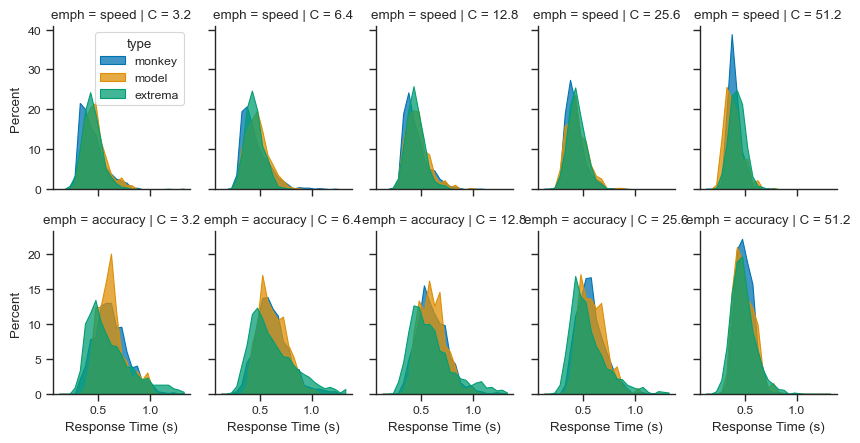

In [21]:
plot_RTs("hanks_model_june21", "hanks_extrema_june21", "hanks2014_behavior", bins=np.arange(0.1, 1.4, 0.05))

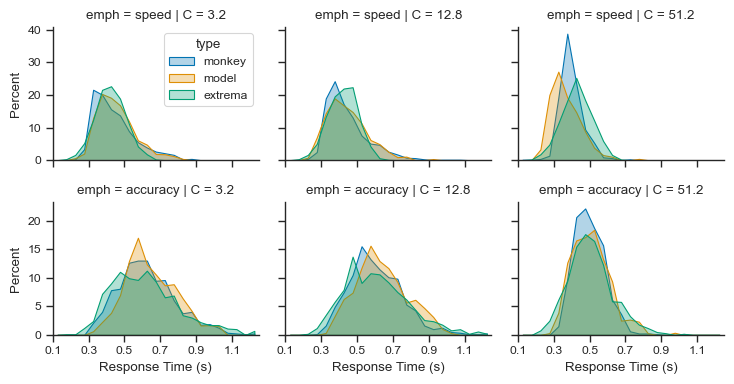

In [37]:
plot_RTs("hanks_sim_shared_may21b", "hanks_extrema_shared_may28", "hanks2014_behavior", bins=np.arange(0.1, 1.3, 0.05))

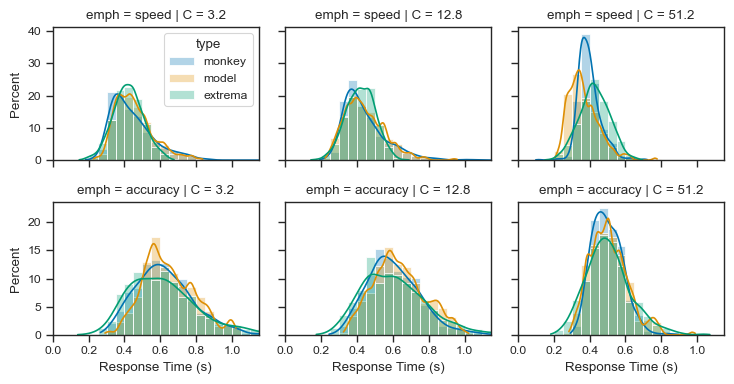

In [13]:
plot_RTs("hanks_sim_shared_may21b", "hanks_extrema_shared_may28", "hanks2014_behavior", bins=np.arange(0.0, 1.2, 0.05), bw=1.0)

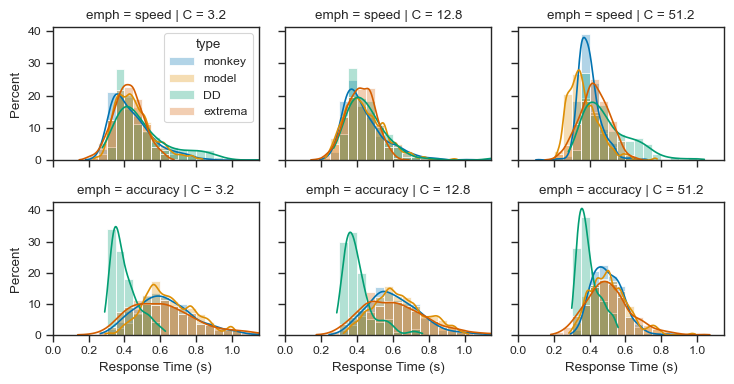

In [4]:
plot_RTs("hanks_sim_shared_may21b", "hanks_extrema_shared_may28", "hanks_dd", "hanks2014_behavior", bins=np.arange(0.0, 1.2, 0.05), bw=1.0)

In [19]:
# plot_correct_incorrect("hanks_sim_shared_may21", "hanks_extrema_shared", "hanks2014_behavior")

In [20]:
# plot_sat("hanks_sim_shared_may21", "hanks_extrema_shared", "hanks2014_behavior")

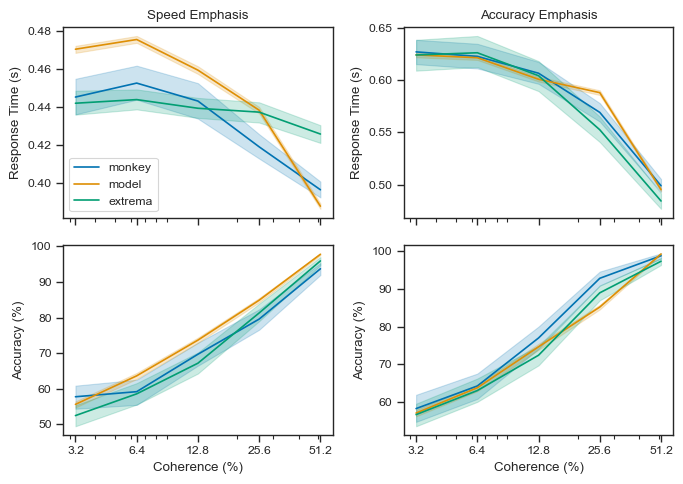

In [22]:
plot_sat2("hanks_model_june21", "hanks_extrema_june21", "hanks2014_behavior", estimator=np.mean)

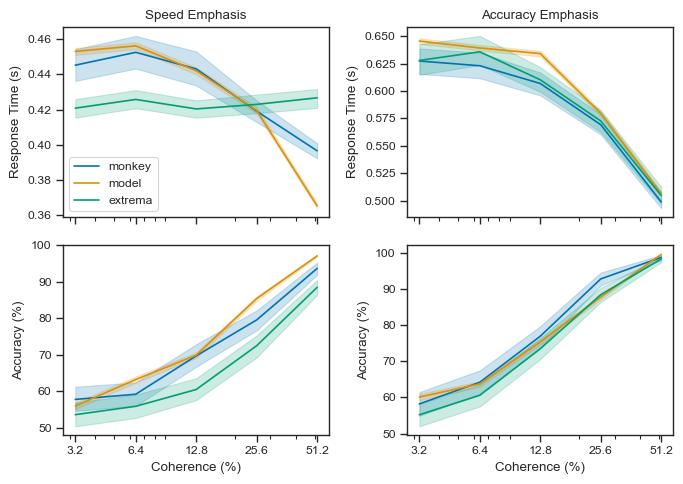

In [27]:
plot_sat2("hanks_sim_shared_may21b", "hanks_extrema_shared_may28", "hanks2014_behavior", estimator=np.mean)

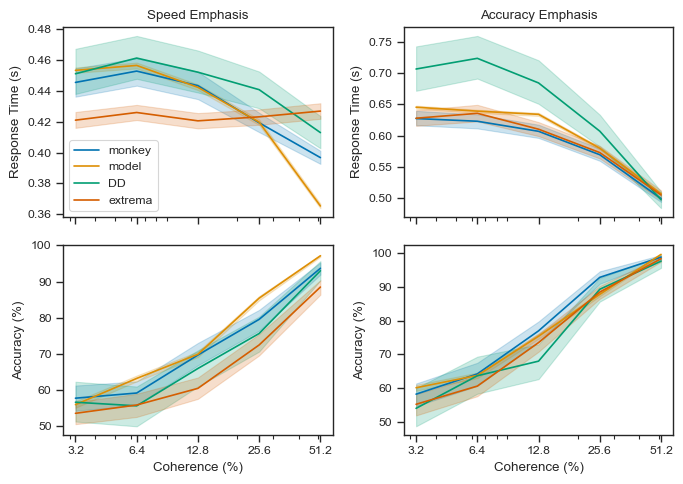

In [7]:
plot_sat2("hanks_sim_shared_may21b", "hanks_extrema_shared_may28", "hanks_DD", "hanks2014_behavior", estimator=np.mean)

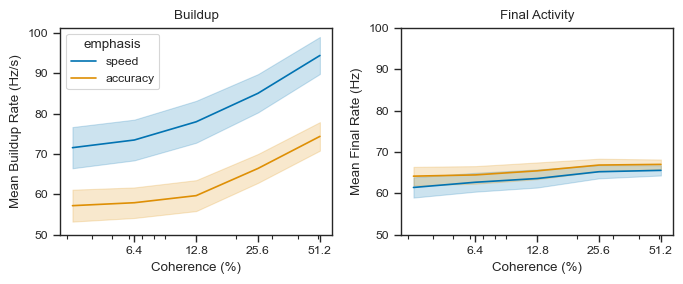

In [61]:
plot_activity("hanks_sim_shared_may21b", "hanks2014_behavior", errorbar=('se', 20))

In [39]:
rate_experiment(
    coherences=[0.032, 0.064, 0.128, 0.256, 0.512],
    trials=100,
    ramps=[1.802, 1.802],
    thresholds=[0.339, 0.458],
    relatives=[0.119, 0.119],
    sigmas=[0.659, 0.659],
    dt_samples=[0.02, 0.02],
    spike_filter=0.01,
    name="rate_experiment_june20",
)

emphasis speed, coherence 0.032
emphasis speed, coherence 0.064
emphasis speed, coherence 0.128
emphasis speed, coherence 0.256
emphasis speed, coherence 0.512
emphasis accuracy, coherence 0.032
emphasis accuracy, coherence 0.064
emphasis accuracy, coherence 0.128
emphasis accuracy, coherence 0.256
emphasis accuracy, coherence 0.512


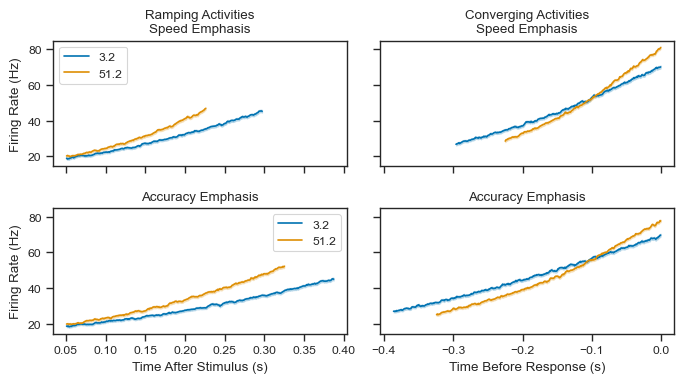

In [67]:
plot_ramping_converging2("rate_experiment_may30", coherences=[3.2, 51.2], stop='min')

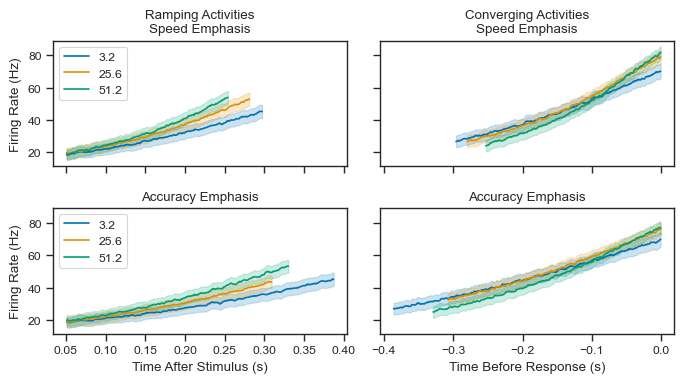

In [50]:
plot_ramping_converging2("rate_experiment_june20", coherences=[3.2, 25.6, 51.2], stop='min')

## Etc

In [37]:
emp = pd.read_pickle(f'data/hanks2014_behavior.pkl').query("id=='E' & coherence>0")
cohs = emp['coherence'].unique()
for coh in cohs:
    print(coh, len(emp.query("coherence==@coh")['trial'].unique()))

25.6 1488
51.2 1460
6.4 1475
3.2 1459
12.8 1486
